# Employee Turnover Prediction

In [20]:

import os, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
RANDOM_STATE = 42
DATA_PATH = r'C:\Users\kgjam\OneDrive\Desktop\10_project\HR_comma_sep.csv'
assert os.path.exists(DATA_PATH), f'Dataset not found at {DATA_PATH}'


In [21]:

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().lower() for c in df.columns]
if 'department' not in df.columns and 'sales' in df.columns:
    df = df.rename(columns={'sales':'department'})
df_imputed = df.copy()
for c in df_imputed.select_dtypes(include='number').columns:
    df_imputed[c]=df_imputed[c].fillna(df_imputed[c].median())
for c in df_imputed.select_dtypes(exclude='number').columns:
    df_imputed[c]=df_imputed[c].fillna(df_imputed[c].mode().iloc[0])
df_imputed.head(3)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


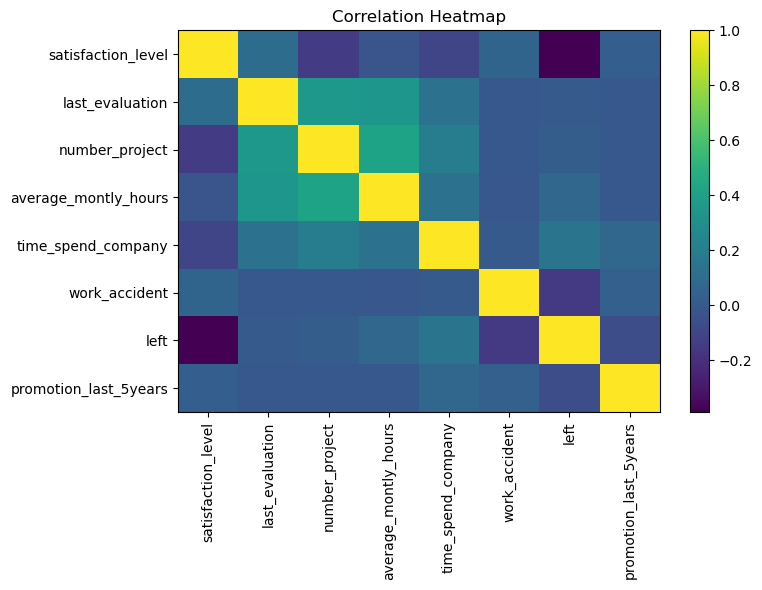

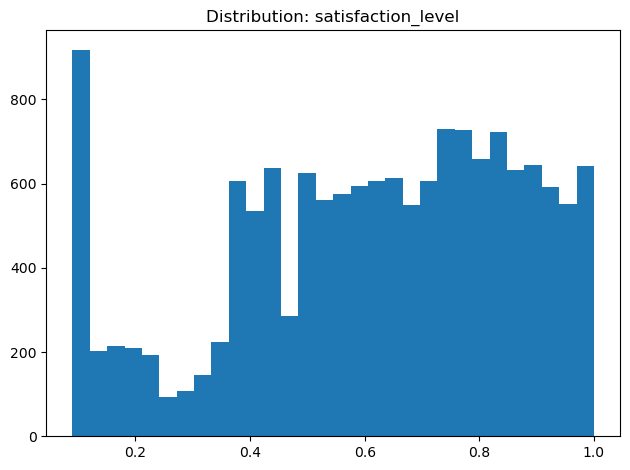

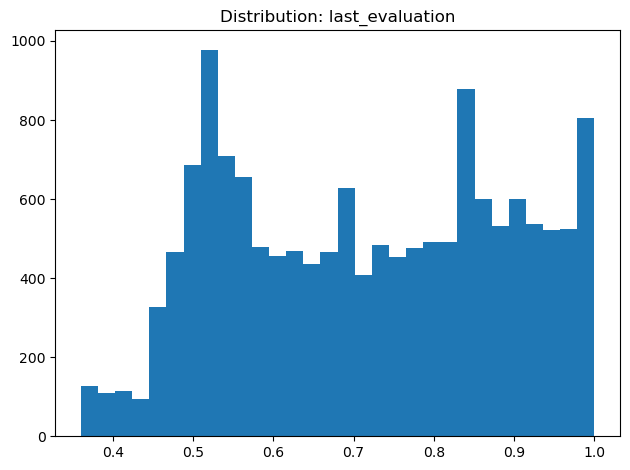

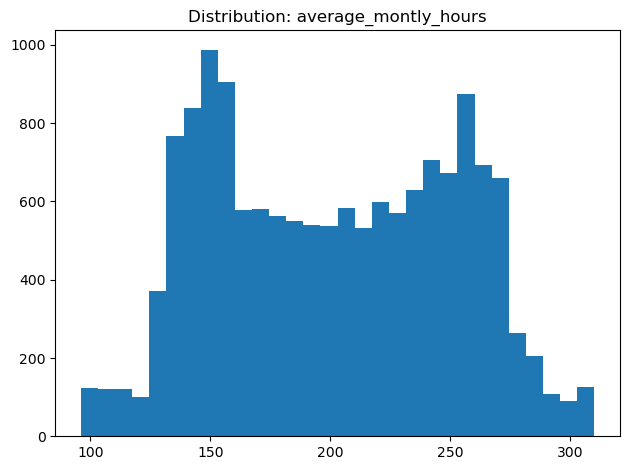

In [22]:

corr = df_imputed.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(8,6)); plt.imshow(corr, aspect='auto'); 
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90); 
plt.yticks(range(len(corr.columns)), corr.columns);
plt.title('Correlation Heatmap'); plt.colorbar(); plt.tight_layout(); plt.show()
for col in ['satisfaction_level','last_evaluation','average_montly_hours']:
    if col in df_imputed.columns:
        plt.figure(); plt.hist(df_imputed[col].dropna(), bins=30)
        plt.title(f'Distribution: {col}'); plt.tight_layout(); plt.show()


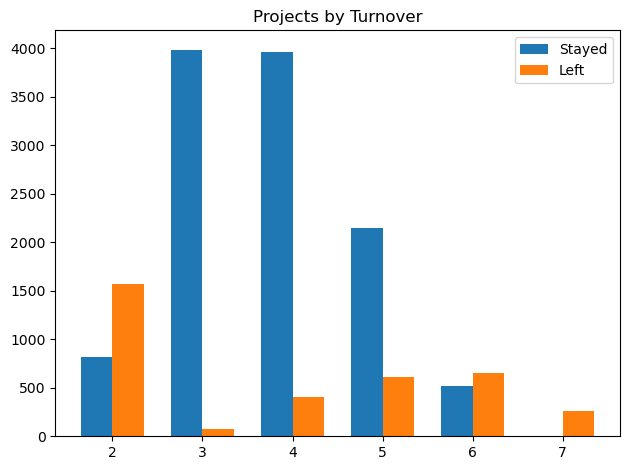

In [23]:

if {'number_project','left'}.issubset(df_imputed.columns):
    grp = df_imputed.groupby(['number_project','left']).size().unstack(fill_value=0)
    import numpy as np
    x = np.arange(len(grp.index)); w=0.35
    plt.figure(); 
    plt.bar(x-w/2, grp.get(0, pd.Series(0, index=grp.index)).values, w, label='Stayed')
    plt.bar(x+w/2, grp.get(1, pd.Series(0, index=grp.index)).values, w, label='Left')
    plt.xticks(x, grp.index); plt.legend(); plt.title('Projects by Turnover'); plt.tight_layout(); plt.show()


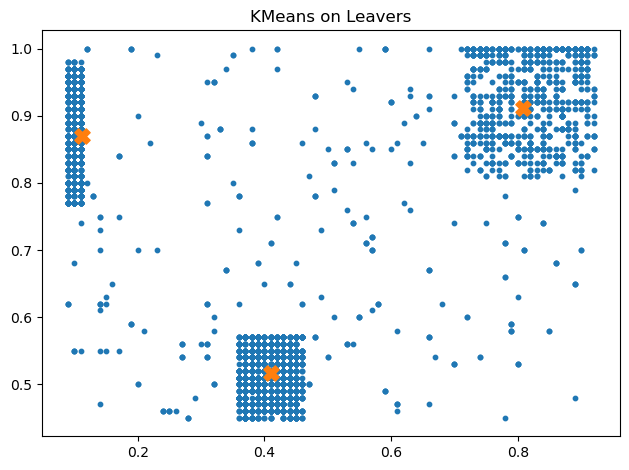

In [24]:

if set(['satisfaction_level','last_evaluation','left']).issubset(df_imputed.columns):
    df_left = df_imputed[df_imputed['left']==1][['satisfaction_level','last_evaluation']].dropna()
    if len(df_left)>=3:
        km = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
        lab = km.fit_predict(df_left.values); ctr = km.cluster_centers_
        plt.figure(); plt.scatter(df_left['satisfaction_level'], df_left['last_evaluation'], s=10)
        plt.scatter(ctr[:,0], ctr[:,1], s=120, marker='X'); plt.title('KMeans on Leavers'); plt.tight_layout(); plt.show()


In [25]:

target_col='left'
y=df_imputed[target_col].astype(int)
cat_cols=[c for c in ['department','salary'] if c in df_imputed.columns]
X_num=df_imputed.drop(columns=[target_col]+cat_cols, errors='ignore')
X_cat=pd.get_dummies(df_imputed[cat_cols].astype(str), drop_first=True) if cat_cols else pd.DataFrame(index=df_imputed.index)
X=pd.concat([X_num,X_cat],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

def naive_oversample(X_df, y_s):
    import numpy as np, pandas as pd
    rng=np.random.default_rng(42)
    c=y_s.value_counts(); maj=c.idxmax(); minc=c.idxmin(); need=c.max()-c.min()
    add=rng.choice(y_s[y_s==minc].index,size=need,replace=True)
    X_new=pd.concat([X_df,X_df.loc[add]]); y_new=pd.concat([y_s,y_s.loc[add]])
    p=rng.permutation(len(y_new)); return X_new.iloc[p], y_new.iloc[p]

try:
    from imblearn.over_sampling import SMOTE
    X_train_bal,y_train_bal=SMOTE(random_state=42).fit_resample(X_train,y_train)
    print('SMOTE used: True')
except Exception:
    X_train_bal,y_train_bal=naive_oversample(X_train,y_train)
    print('SMOTE used: False (fallback)')


SMOTE used: True


In [26]:

cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models={'LogisticRegression':LogisticRegression(max_iter=1000,random_state=42),
        'RandomForest':RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1),
        'GradientBoosting':GradientBoostingClassifier(random_state=42)}
cv_reports={}
for n,m in models.items():
    ycv=cross_val_predict(m,X_train_bal,y_train_bal,cv=cv,n_jobs=-1)
    rep=classification_report(y_train_bal,ycv,output_dict=True,zero_division=0)
    import pandas as pd
    cv_reports[n]=pd.DataFrame(rep).T
    print(f"\n=== {n} CV Report ==="); display(cv_reports[n])



=== LogisticRegression CV Report ===


,precision,recall,f1-score,support
0,0.810186,0.770838,0.790022,9142.000000
1,0.781452,0.819405,0.799979,9142.000000
accuracy,0.795121,0.795121,0.795121,0.795121
macro avg,0.795819,0.795121,0.795001,18284.000000
weighted avg,0.795819,0.795121,0.795001,18284.000000



=== RandomForest CV Report ===


,precision,recall,f1-score,support
0,0.974290,0.994859,0.984467,9142.000000
1,0.994748,0.973748,0.984136,9142.000000
accuracy,0.984303,0.984303,0.984303,0.984303
macro avg,0.984519,0.984303,0.984301,18284.000000
weighted avg,0.984519,0.984303,0.984301,18284.000000



=== GradientBoosting CV Report ===


,precision,recall,f1-score,support
0,0.949851,0.975826,0.962663,9142.000000
1,0.975146,0.948480,0.961628,9142.000000
accuracy,0.962153,0.962153,0.962153,0.962153
macro avg,0.962499,0.962153,0.962146,18284.000000
weighted avg,0.962499,0.962153,0.962146,18284.000000


<Figure size 640x480 with 0 Axes>

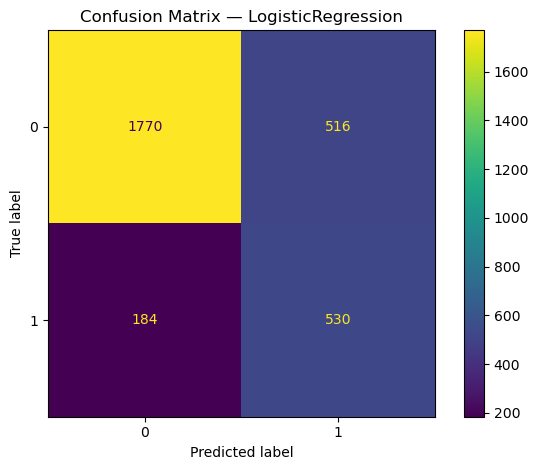

<Figure size 640x480 with 0 Axes>

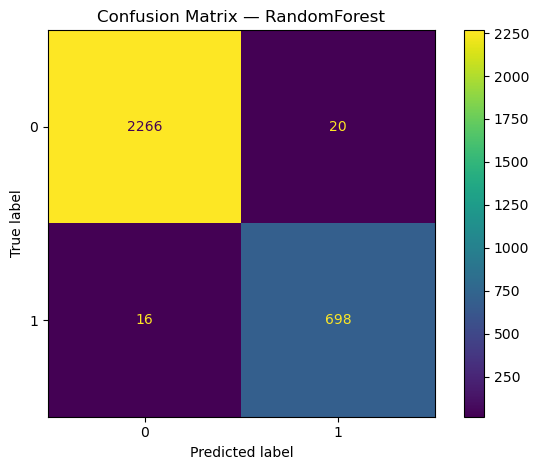

<Figure size 640x480 with 0 Axes>

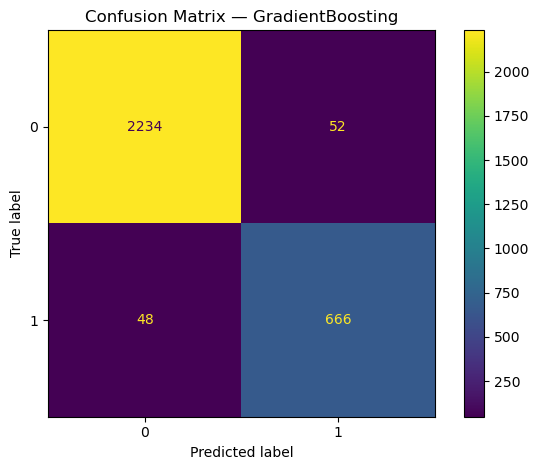

,model,roc_auc,precision_1,recall_1,f1_1
1,RandomForest,0.995422,0.972145,0.977591,0.974860
2,GradientBoosting,0.986172,0.927577,0.932773,0.930168
0,LogisticRegression,0.816204,0.506692,0.742297,0.602273


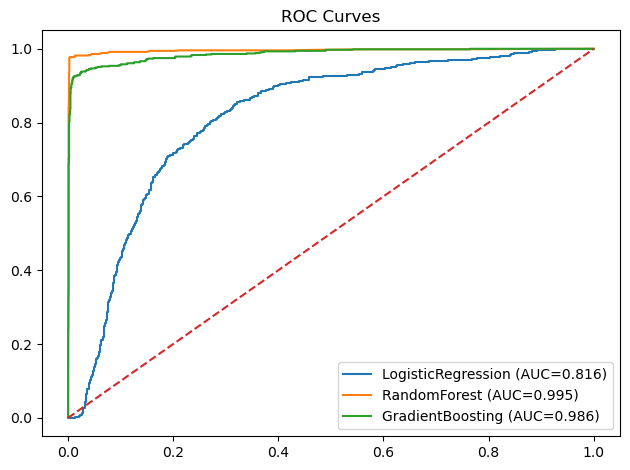

In [27]:

test_metrics=[]; roc_curves={}
for n,m in models.items():
    m.fit(X_train_bal,y_train_bal)
    import numpy as np
    if hasattr(m,'predict_proba'): pro=m.predict_proba(X_test)[:,1]
    elif hasattr(m,'decision_function'):
        d=m.decision_function(X_test); pro=(d-d.min())/(d.max()-d.min()+1e-9)
    else: pro=m.predict(X_test).astype(float)
    fpr,tpr,_=roc_curve(y_test,pro); from sklearn.metrics import auc
    roc_auc=auc(fpr,tpr); roc_curves[n]=(fpr,tpr,roc_auc)
    yhat=(pro>=0.5).astype(int); cm=confusion_matrix(y_test,yhat,labels=[0,1])
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    plt.figure(); disp.plot(); plt.title(f'Confusion Matrix — {n}'); plt.tight_layout(); plt.show()
    p1=cm[1,1]/(cm[0,1]+cm[1,1]+1e-9); r1=cm[1,1]/(cm[1,0]+cm[1,1]+1e-9)
    f1=2*(p1*r1)/(p1+r1+1e-9); test_metrics.append({'model':n,'roc_auc':roc_auc,'precision_1':p1,'recall_1':r1,'f1_1':f1})
import pandas as pd
test_df=pd.DataFrame(test_metrics).sort_values('roc_auc',ascending=False); display(test_df)
plt.figure()
for n,(fpr,tpr,roc_auc) in roc_curves.items():
    plt.plot(fpr,tpr,label=f"{n} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title('ROC Curves'); plt.tight_layout(); plt.show()


## 11. Feature Importance — Random Forest & Gradient Boosting

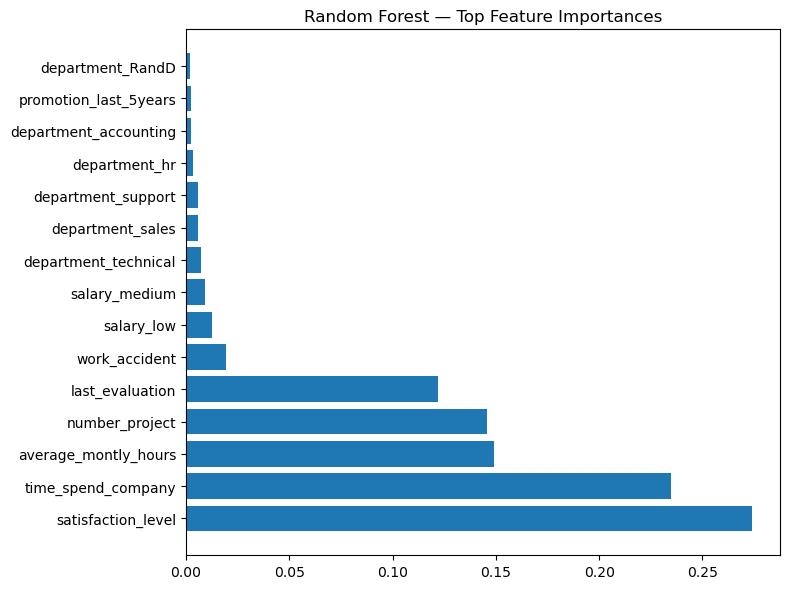

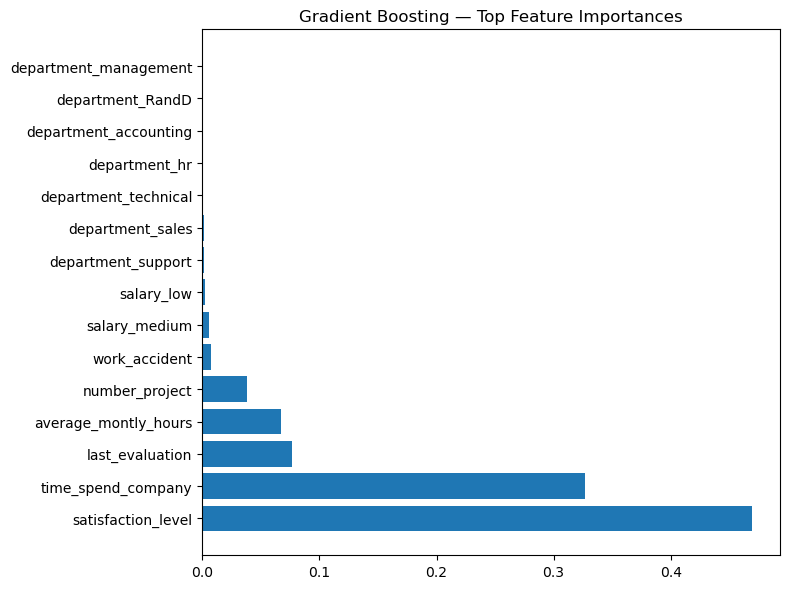

In [28]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
gb = GradientBoostingClassifier(random_state=42)

rf.fit(X_train_bal, y_train_bal)
gb.fit(X_train_bal, y_train_bal)

def plot_top_importances(model, feature_names, top_n=15, title="Feature Importance"):
    import numpy as np, matplotlib.pyplot as plt
    imps = model.feature_importances_
    idx = np.argsort(imps)[-top_n:][::-1]   # top N in descending order
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idx)), imps[idx])
    plt.yticks(range(len(idx)), [feature_names[i] for i in idx])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ✅ correct calls
plot_top_importances(rf, X_train_bal.columns.tolist(), title="Random Forest — Top Feature Importances")
plot_top_importances(gb, X_train_bal.columns.tolist(), title="Gradient Boosting — Top Feature Importances")
# or: plot_top_importances(rf, X_train_bal.columns.tolist(), 15, "Random Forest — Top Feature Importances")


## 12. SHAP Explanations — Why did the model predict that?

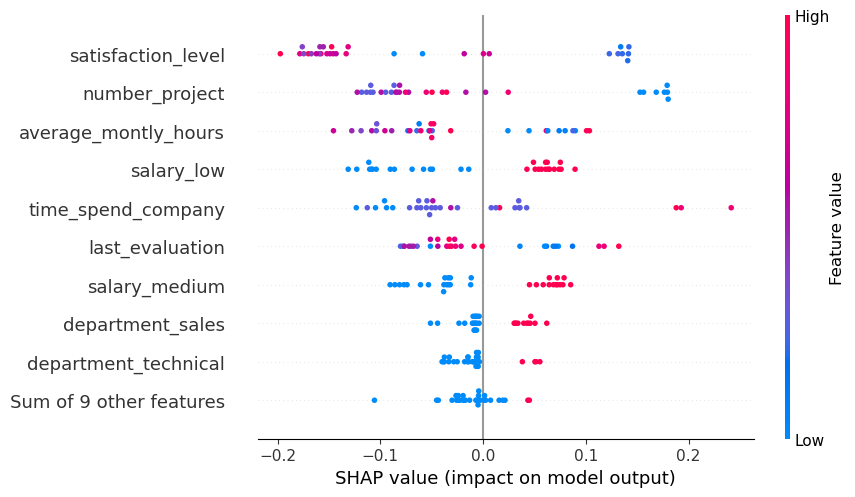

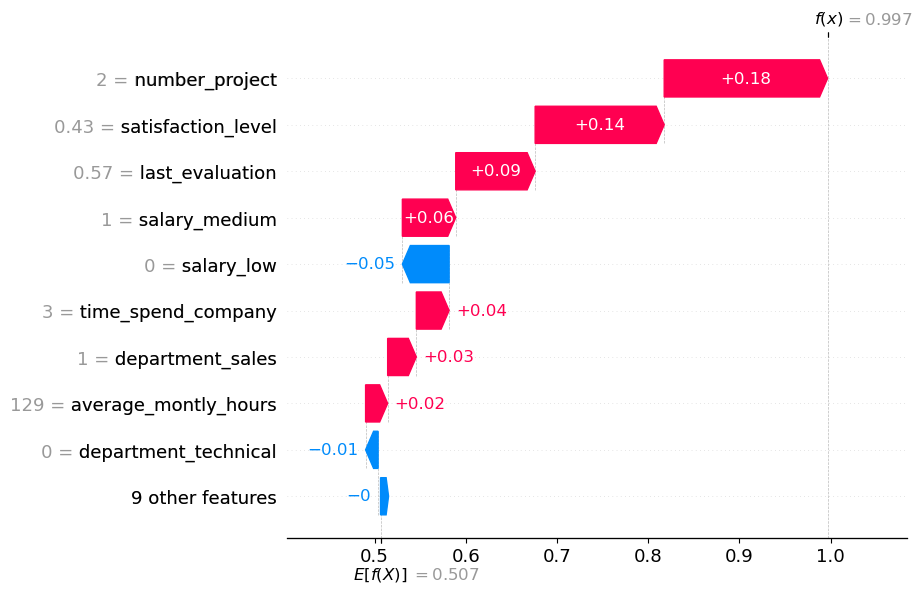

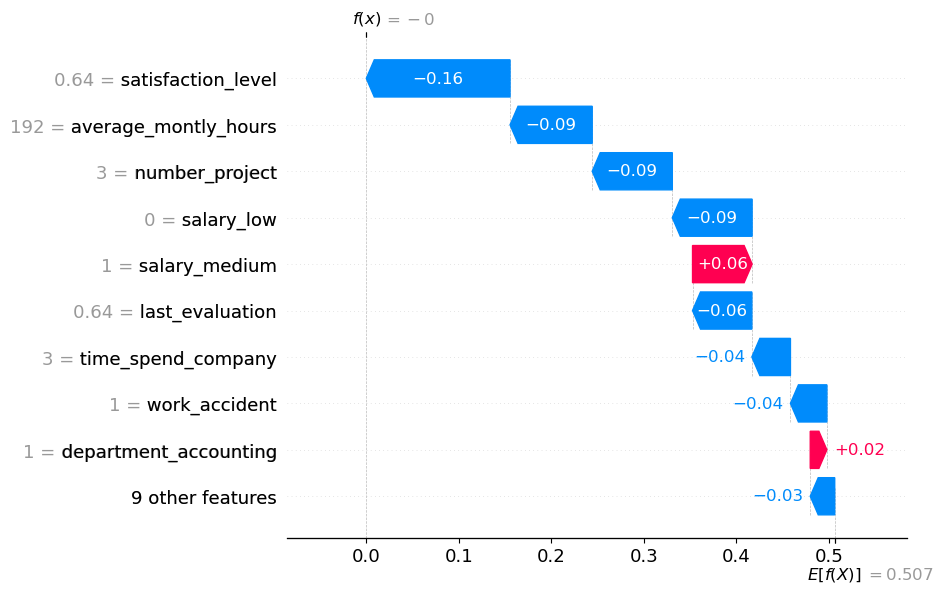

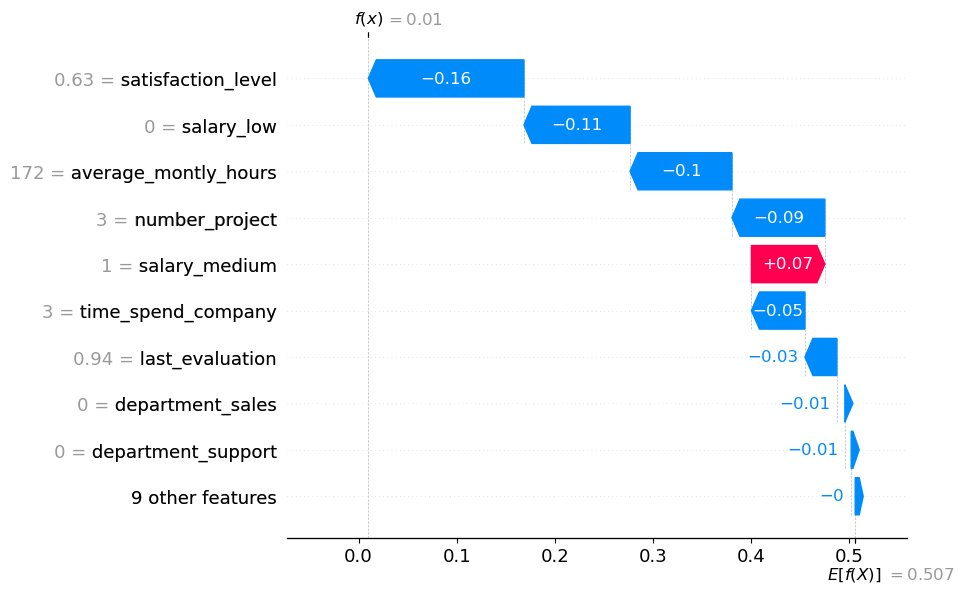

In [46]:
# --- SAFE SHAP CELL: works for RF/GB/LogReg, fixes dtype issues, handles binary class ---

import numpy as np, pandas as pd, shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# 1) Choose a model to explain
model_to_explain = None
try:
    model_to_explain = best_model          # if you set best_model earlier
except NameError:
    pass

# Fallbacks if best_model not defined
if model_to_explain is None:
    if 'rf' in globals():
        model_to_explain = rf
    elif 'gb' in globals():
        model_to_explain = gb
    else:
        # last resort: pick a tree model you trained inside "models"
        try:
            model_to_explain = models.get("RandomForest", None) or models.get("GradientBoosting", None)
        except Exception:
            pass

if model_to_explain is None:
    raise RuntimeError("No trained model found to explain. Ensure best_model/rf/gb is trained.")

# 2) Ensure SHAP inputs are numeric floats and columns align with training
Xtr = pd.DataFrame(X_train_bal).copy()
Xte = pd.DataFrame(X_test).copy()
# force numeric (convert non-numeric to NaN, then fill)
Xtr = Xtr.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)
Xte = Xte[Xtr.columns].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)

# 3) Build a masker (background). Use a small random sample for speed/stability
bg = shap.maskers.Independent(Xtr.sample(min(500, len(Xtr)), random_state=42))

# Pick algorithm by model type
if isinstance(model_to_explain, (RandomForestClassifier, GradientBoostingClassifier)):
    algorithm = "tree"
elif isinstance(model_to_explain, LogisticRegression):
    algorithm = "linear"
else:
    algorithm = "auto"  # generic fallback

# We want probabilities for a classifier
explainer = shap.Explainer(model_to_explain, bg, algorithm=algorithm, model_output="probability", feature_names=Xtr.columns)

# Explain a small slice of test set
X_sample = Xte.sample(min(30, len(Xte)), random_state=42)
ex = explainer(X_sample)

# 4) If binary classifier returns per-class values, select positive class (index 1)
vals = getattr(ex, "values", None)
if vals is not None and vals.ndim == 3:  # shape: (n_samples, n_features, n_classes)
    ex = shap.Explanation(
        values=ex.values[:, :, 1],
        base_values=ex.base_values[:, 1],
        data=ex.data,
        feature_names=ex.feature_names
    )

# 5) Global importance
try:
    shap.plots.beeswarm(ex, show=True)
except Exception:
    shap.plots.bar(ex, show=True)

# 6) Local explanations for a few samples (waterfall needs a single vector)
n_show = min(3, len(X_sample))
for i in range(n_show):
    try:
        shap.plots.waterfall(ex[i], show=True)
    except Exception:
        shap.plots.bar(ex[i], show=True)


## 13. Model Comparison Summary — CV vs Test

In [30]:

import pandas as pd
rows=[]
for n,rep in cv_reports.items():
    w = rep.loc['weighted avg','f1-score'] if 'weighted avg' in rep.index else None
    m = rep.loc['macro avg','f1-score'] if 'macro avg' in rep.index else None
    rows.append({'model':n,'cv_f1_weighted':w,'cv_f1_macro':m})
cv_sum_df=pd.DataFrame(rows)
comp_df=cv_sum_df.merge(test_df, on='model', how='right') if 'test_df' in globals() else cv_sum_df
if 'roc_auc' in comp_df.columns: comp_df=comp_df.sort_values('roc_auc',ascending=False)
display(comp_df)


,model,cv_f1_weighted,cv_f1_macro,roc_auc,precision_1,recall_1,f1_1
0,RandomForest,0.984301,0.984301,0.995422,0.972145,0.977591,0.974860
1,GradientBoosting,0.962146,0.962146,0.986172,0.927577,0.932773,0.930168
2,LogisticRegression,0.795001,0.795001,0.816204,0.506692,0.742297,0.602273


## 14. Threshold Tuning — pick an operating point

,threshold,precision,recall,f1
0,0.000,0.238000,1.000000,0.384491
1,0.005,0.305223,0.998599,0.467541
2,0.010,0.357752,0.998599,0.526782
3,0.015,0.396216,0.997199,0.567105
4,0.020,0.428313,0.995798,0.598989


Best F1 threshold:


,threshold,precision,recall,f1
97,0.645,0.992877,0.97619,0.984463


Recall-first (≥0.80) threshold:


,threshold,precision,recall,f1
137,0.985,0.996564,0.812325,0.895062


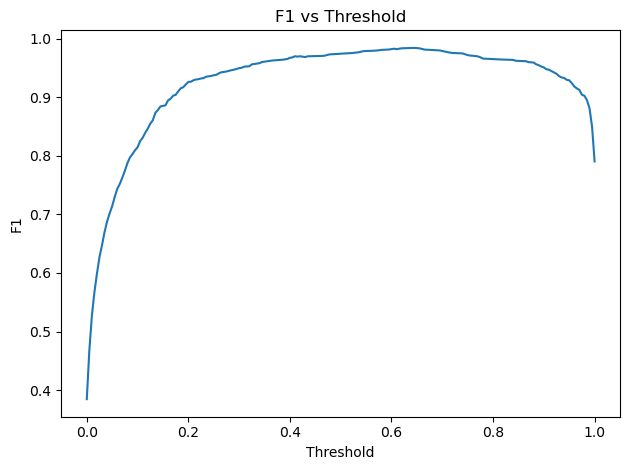

In [31]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
best_name=test_df.iloc[0]['model']; best_model=models[best_name]; best_model.fit(X_train_bal,y_train_bal)
if hasattr(best_model,'predict_proba'): pro=best_model.predict_proba(X_test)[:,1]
elif hasattr(best_model,'decision_function'):
    d=best_model.decision_function(X_test); pro=(d-d.min())/(d.max()-d.min()+1e-9)
else: pro=best_model.predict(X_test).astype(float)
prec,rec,thr=precision_recall_curve(y_test,pro); thr=np.append(thr,1.0)
f1s=[f1_score(y_test,(pro>=t).astype(int),zero_division=0) for t in thr]
thr_df=pd.DataFrame({'threshold':thr,'precision':prec,'recall':rec,'f1':f1s}).sort_values('threshold')
display(thr_df.head())
best_f1_row=thr_df.iloc[thr_df['f1'].idxmax()]; print("Best F1 threshold:"); display(best_f1_row.to_frame().T)
target=0.80; cand=thr_df[thr_df['recall']>=target]
if len(cand): rr=cand.sort_values('threshold').tail(1).iloc[0]; print(f"Recall-first (≥{target:.2f}) threshold:"); display(rr.to_frame().T)
else: print(f"No threshold reached recall ≥ {target:.2f}.")
plt.figure(); plt.plot(thr_df['threshold'],thr_df['f1']); plt.xlabel('Threshold'); plt.ylabel('F1'); plt.title('F1 vs Threshold'); plt.tight_layout(); plt.show()


## 10.a Class Balance — Before vs After SMOTE
This cell plots the class distribution **before** and **after** SMOTE to verify balancing of the target (`left`).

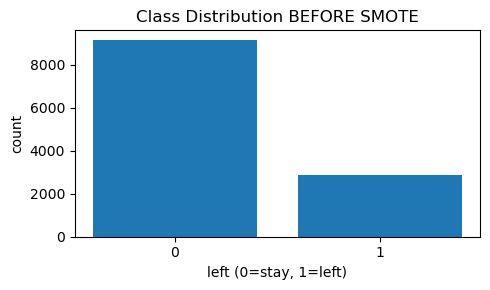

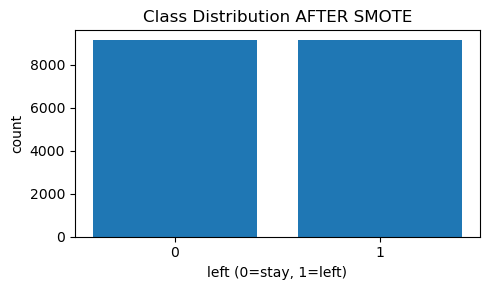

In [32]:

# Ensure RANDOM_STATE is defined
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def _bar_counts(counts, title):
    labels = sorted(list(counts.keys()))
    values = [counts[k] for k in labels]
    plt.figure(figsize=(5,3))
    plt.bar([str(l) for l in labels], values)
    plt.title(title)
    plt.xlabel("left (0=stay, 1=left)")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Attempt to infer class counts before/after SMOTE
before_counts = None
after_counts = None

if 'y_train' in globals():
    before_counts = Counter(pd.Series(y_train).astype(int))
elif 'y' in globals():
    before_counts = Counter(pd.Series(y).astype(int))

if 'y_train_bal' in globals():
    after_counts = Counter(pd.Series(y_train_bal).astype(int))

if before_counts is not None:
    _bar_counts(before_counts, "Class Distribution BEFORE SMOTE")
else:
    print("Could not find y_train or y. Skipping 'before' plot.")

if after_counts is not None:
    _bar_counts(after_counts, "Class Distribution AFTER SMOTE")
else:
    print("Could not find y_train_bal. Skipping 'after' plot.")


## 12. Model Training (5-Fold CV), Comparison Table, ROC Curves
This cell (re)trains Logistic Regression, Random Forest, and Gradient Boosting on the **SMOTE-balanced** training set, evaluates on the held-out test set, and builds a comparison table. It also plots ROC curves.

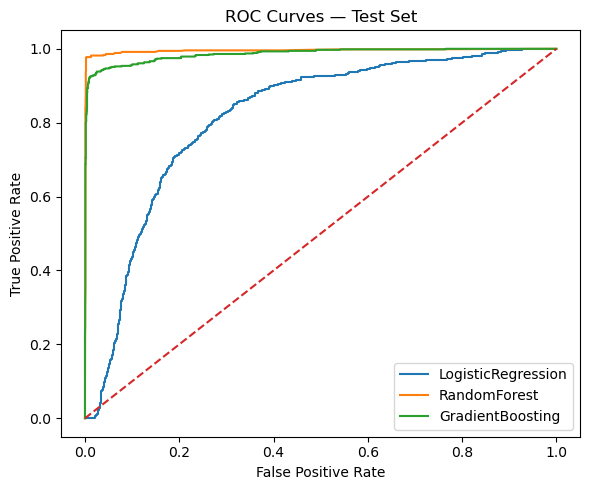

In [34]:
# Plot ROC curves (robust to 2- or 3-tuple entries)
plt.figure(figsize=(6,5))
for name, vals in roc_curves.items():
    # handle (fpr, tpr) or (fpr, tpr, thresholds)
    fpr, tpr = vals[:2]
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Test Set")
plt.legend()
plt.tight_layout()
plt.show()


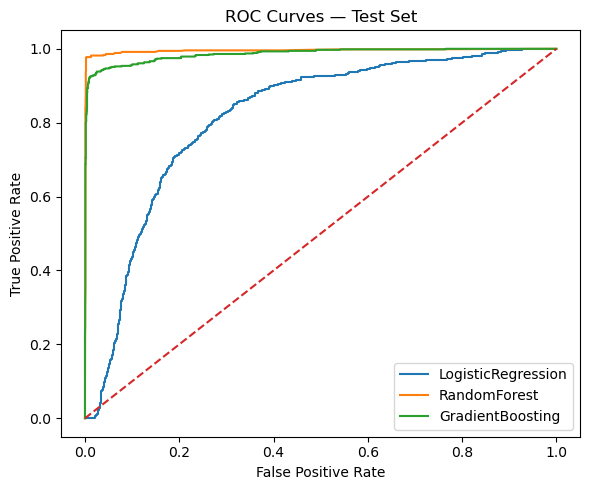

In [36]:
# Plot ROC curves (works whether each value is 2-tuple or 3-tuple)
plt.figure(figsize=(6,5))
for name, vals in roc_curves.items():
    fpr, tpr = vals[:2]    # grab only the first two
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Test Set")
plt.legend()
plt.tight_layout()
plt.show()


## 13. Confusion Matrices & When to Prefer Recall vs Precision
This cell prints confusion matrices for all models and provides guidance on metric choice.

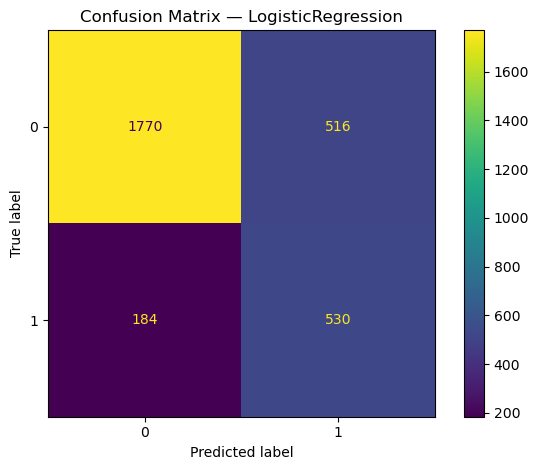

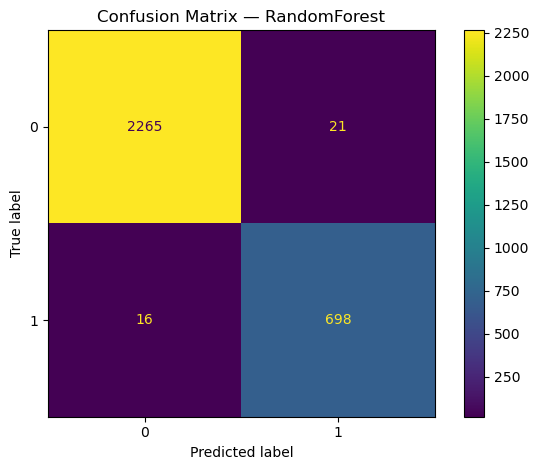

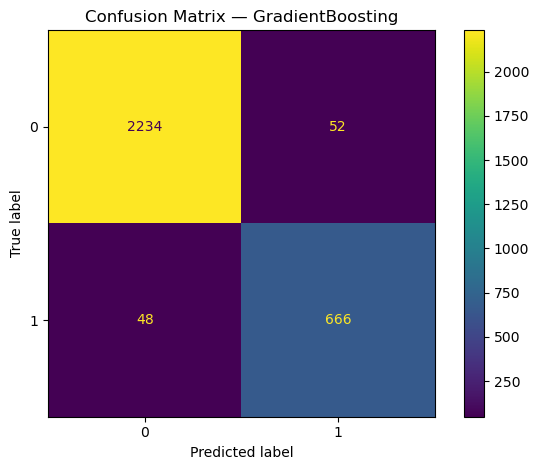


**Metric choice (Recall vs Precision):**
- If the cost of *missing* a soon-to-leave employee is high (lost knowledge, hiring cost), prioritize **Recall** (catch as many leavers as possible).
- If the cost of false alarms is high (unnecessary interventions), prioritize **Precision**.
- In HR churn contexts, **Recall** (and **ROC_AUC/F1**) are often emphasized to avoid missing at-risk employees, with a practical review of Precision to control intervention costs.



In [37]:

from sklearn.metrics import ConfusionMatrixDisplay

if 'best_model_name' not in globals():
    print("Please run the previous cell to compute results and best_model_name.")
else:
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
        "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
    }
    for name, model in models.items():
        model.fit(X_train_bal, y_train_bal)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
        else:
            if hasattr(model, "decision_function"):
                d = model.decision_function(X_test)
                y_proba = (d - d.min()) / (d.max() - d.min() + 1e-9)
            else:
                y_proba = model.predict(X_test)

        y_pred = (y_proba >= 0.5).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix — {name}")
        plt.tight_layout()
        plt.show()

print(
"""
**Metric choice (Recall vs Precision):**
- If the cost of *missing* a soon-to-leave employee is high (lost knowledge, hiring cost), prioritize **Recall** (catch as many leavers as possible).
- If the cost of false alarms is high (unnecessary interventions), prioritize **Precision**.
- In HR churn contexts, **Recall** (and **ROC_AUC/F1**) are often emphasized to avoid missing at-risk employees, with a practical review of Precision to control intervention costs.
"""
)


## 14. Turnover Probability, Risk Zoning & Retention Strategies
Using the **best model**, we score the test set, assign risk zones, and propose targeted actions.

In [39]:
# Train the best model on balanced train set, score the test set, and assign zones
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

if 'best_model_name' not in globals():
    best_model_name = "GradientBoosting"  # safe default

best_model = models[best_model_name].fit(X_train_bal, y_train_bal)

if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)[:,1]
elif hasattr(best_model, "decision_function"):
    d = best_model.decision_function(X_test)
    proba = (d - d.min()) / (d.max() - d.min() + 1e-9)
else:
    proba = best_model.predict(X_test).astype(float)

def zone(p):
    if p < 0.20: return "Safe (Green)"
    if p < 0.60: return "Low-Risk (Yellow)"
    if p < 0.90: return "Medium-Risk (Orange)"
    return "High-Risk (Red)"

summary_df = pd.DataFrame({
    "turnover_proba": proba,
    "risk_zone": [zone(p) for p in proba]
})

# Show results
display(summary_df.head(50))

print("Zone distribution:\n", summary_df['risk_zone'].value_counts())


,turnover_proba,risk_zone
0,0.000000,Safe (Green)
1,0.620000,Medium-Risk (Orange)
2,0.023333,Safe (Green)
3,0.003333,Safe (Green)
4,0.000000,Safe (Green)
5,0.013333,Safe (Green)
6,0.003333,Safe (Green)
7,0.003333,Safe (Green)
8,0.003333,Safe (Green)
9,0.000000,Safe (Green)


Zone distribution:
 risk_zone
Safe (Green)            2192
High-Risk (Red)          655
Low-Risk (Yellow)        102
Medium-Risk (Orange)      51
Name: count, dtype: int64



### Suggested Retention Strategies by Zone
- **Safe (Green, <20%)**: Maintain engagement, recognition; provide career path visibility and periodic check-ins.
- **Low-Risk (Yellow, 20–60%)**: Monitor workload, manager 1:1s, flexible scheduling, peer mentoring, skills training.
- **Medium-Risk (Orange, 60–90%)**: Targeted interventions — role fit assessment, project rotation, compensation review, manager coaching, pulse surveys.
- **High-Risk (Red, >90%)**: Immediate action — retention interview, tailored incentives (bonus, role change), workload adjustment, executive sponsorship, fast-track development plan.


## 15. Visualization of Retention Risk Zones
To complement the retention strategies, here we visualize the distribution of employees across the four risk zones using a bar chart and a pie chart.

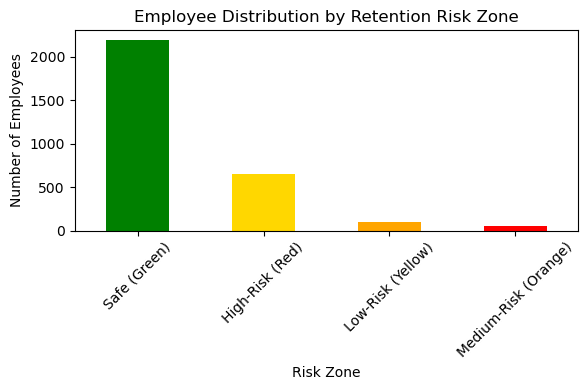

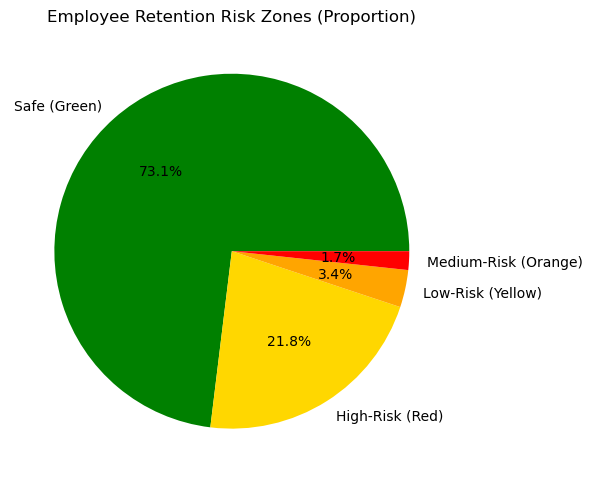

In [40]:

import matplotlib.pyplot as plt

if 'summary_df' not in globals():
    print("Please run the probability scoring cell first to generate summary_df.")
else:
    zone_counts = summary_df['risk_zone'].value_counts()

    # Bar Chart
    plt.figure(figsize=(6,4))
    zone_counts.plot(kind='bar', color=['green','gold','orange','red'])
    plt.title("Employee Distribution by Retention Risk Zone")
    plt.xlabel("Risk Zone")
    plt.ylabel("Number of Employees")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Pie Chart
    plt.figure(figsize=(6,6))
    zone_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green','gold','orange','red'])
    plt.ylabel("")
    plt.title("Employee Retention Risk Zones (Proportion)")
    plt.tight_layout()
    plt.show()
